In [1]:
# Importing dependencies

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import json
import requests
import yfinance as yf
import pandas as pd
from apikeys import alpha_api_FJDG
from apikeys import alpha_api_AZ
from apikeys import alpha_api_AB
import numpy as np
import time
import time
import ipywidgets as widgets
from IPython.display import display

# Stocks Analysis For Distribution Of Capital 

In [2]:
# API calls have limitations so we're calling 4 stocks at a time

# First call
stocks=["AAPL","AMD","TSLA","META"]
alpha_api = alpha_api_AB  # API key
df1 = pd.DataFrame()  # Empty DataFrame to store the concatenated df's

# Lets loop through the call!
for stock in stocks:
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={alpha_api}&outputsize=full'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data["Time Series (Daily)"])
    df = df.iloc[:, :365].T
    df.reset_index(inplace=True, drop=False)
    df.columns = ['Dates', 'Open','High','Low','Close','Volume']
    df['Ticker'] = stock
    df = df[["Ticker","Dates","Open","Close","Volume"]]
    df1 = pd.concat([df1, df], axis=0)  # Concatenate the dataframes vertically

In [3]:
#df1.info()
#df1

In [4]:
# Setting a function to showcase "waiting" time period between API calls
# DO NOT SKIP! API Call is limited, wait time must be respected to 5 min apart
def api_waiting_period():
    progress = widgets.IntProgress(
        value=0,
        min=0,
        max=300,
        description='Progress:',
        bar_style='info',
    )
    display(progress)
    
    for i in range(301):
        time.sleep(1)  # count unit
        progress.value = i

In [5]:
#Running progress status bar

api_waiting_period()

IntProgress(value=0, bar_style='info', description='Progress:', max=300)

In [6]:
# Second call

stocks_2=["AMZN","INTC","MSFT","NVDA"]
alpha_api_2 = alpha_api_AB  # API key
df2 = pd.DataFrame()  # Empty DataFrame to store the concatenated df's

# Lets loop through the call!
for stock in stocks_2:
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={alpha_api_2}&outputsize=full'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data["Time Series (Daily)"])
    df = df.iloc[:, :365].T
    df.reset_index(inplace=True, drop=False)
    df.columns = ['Dates', 'Open','High','Low','Close','Volume']
    df['Ticker'] = stock
    df = df[["Ticker","Dates","Open","Close","Volume"]]
    df2 = pd.concat([df2, df], axis=0)  # Concatenate the dataframes vertically
    

In [7]:
#df2.info()
#df2

### Stock Closing Price & Delta (Weekly) 

In [8]:
# Merging dataframes (Still want to keep df with all stock data)
all_stocks=pd.concat([df1, df2], axis=0)
all_stocks['Dates'] = pd.to_datetime(all_stocks['Dates'])
all_stocks = all_stocks.sort_values(by='Dates', ascending=True)
all_stocks = all_stocks.reset_index(drop=True)

# Cleaning dataframe for desired values only
all_stocks_clean = all_stocks.loc[:, ['Ticker', 'Dates','Close']]

#Display df
all_stocks_clean

,Ticker,Dates,Close
0,META,2022-05-11,188.7400
1,MSFT,2022-05-11,260.5500
2,INTC,2022-05-11,42.8300
3,AMZN,2022-05-11,2107.4400
4,TSLA,2022-05-11,734.0000
...,...,...,...
2915,TSLA,2023-10-23,212.0800
2916,NVDA,2023-10-23,429.7500
2917,AMD,2023-10-23,100.0100
2918,AMZN,2023-10-23,126.5600


In [20]:
#Creating a function for timeseries line charts

def my_line_chart(dataframe, stock):
    # Creating a line chart
    fig = px.line(dataframe, x='Dates', y=['DELTA'], labels={'value': 'Price Change'}, title=f'{stock} Delta Over Time')

    # Customizing chart 
    fig.update_layout(
        xaxis_title='Dates',
        yaxis_title="Delta",
        legend_title='Price Type',
        xaxis=dict(tickformat='%b %d, %Y'),  # Formatting x-axis labels
        title_x=0.5,  # (Centering title)
        title_y=0.95,
    )

    # Display chart
    fig.show()

### Stock Growth Trend Time Series (Delta)

In [21]:
# Creating list of stocks
my_stocks=["AAPL","AMD","TSLA","META","AMZN","INTC","MSFT","NVDA"]

for stock in my_stocks:
# Filtering stock data
    mydf=all_stocks_clean.query(f"Ticker == '{stock}'")
    mydf = pd.DataFrame(mydf)
    mydf.set_index('Dates', inplace=True)
# Moving from daily to weekly
    mydf = mydf.resample('W').last()
    mydf.reset_index(inplace=True)
# Getting delta
    mydf_delta=mydf
    mydf_delta['Close'] = pd.to_numeric(mydf_delta['Close'], errors='coerce')
    mydf_delta["DELTA"]=mydf_delta['Close'].pct_change()
    data = mydf_delta.query(f"Ticker == '{stock}'")
#Running function
    my_line_chart(data,stock)


### Stock Beta & PE Ratio

In [11]:
# Looping stock data from Yahoo Finance

# Lists to store the data
stock_data = []
stock_betas = []
stock_pe_ratios = []

for stock in my_stocks:
    # Download yahoo finance data
    data = yf.download(stock, start='2022-11-01', end='2022-12-31')
    
    # Ticker for stock
    ticker = yf.Ticker(stock)
    
    # Get beta
    beta = ticker.info.get('beta', 'N/A')
    
    # Get P/E ratio - if not available then input 'N/A'
    pe_ratio = ticker.info.get('trailingPE', 'N/A')
    
    # Append the data to my empty lists
    stock_data.append(data)
    stock_betas.append(beta)
    stock_pe_ratios.append(pe_ratio)

# Creating dictionary to store data
data_dict = {
    'Stock': my_stocks,
    'Beta': stock_betas,
    'PE Ratio': stock_pe_ratios
}

# Create & clean df
stock_df = pd.DataFrame(data_dict)
stock_df['PE Ratio'].replace('N/A', 0, inplace=True) #Replacing "N/A" with "0"
stock_df = stock_df.round({'Beta': 2, 'PE Ratio': 2})
stock_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Stock,Beta,PE Ratio
0,AAPL,1.31,29.03
1,AMD,1.65,0.00
2,TSLA,2.25,60.25
3,META,1.21,36.60
4,AMZN,1.19,100.44
5,INTC,0.89,0.00
6,MSFT,0.90,34.06
7,NVDA,1.68,103.80


In [12]:
# Function for Beta and PE bar charts

def my_bar_chart(metric):
    fin_data = stock_df[['Stock', f"{metric}"]]
    fin_frame = pd.DataFrame(fin_data)

    fig = px.bar(fin_frame, x='Stock', y=f'{metric}', labels={'Beta': 'Beta Value'}, title=f'{metric} Values per Stock')
    fig.update_layout(xaxis_title='Stock', yaxis_title=f"{metric}", title_x=0.5, title_y=0.95),
    fig.show()


In [13]:
# List with metrics titles
metrics=["Beta","PE Ratio"]

#Lopping through Beta and PE metrics
for metric in metrics:
    my_bar_chart(metric)

In [16]:
# Creating function for bollinger bands chart and calculations

def my_bollinger(stock_df):

# Calculate the moving average and sdev for the closing price
    stock_df.loc[:, 'Rolling Mean'] = stock_df['Close'].rolling(window=rolling_window).mean()
    stock_df.loc[:, 'Upper Band'] = stock_df['Rolling Mean'] + 2 * stock_df['Close'].rolling(window=rolling_window).std()
    stock_df.loc[:, 'Lower Band'] = stock_df['Rolling Mean'] - 2 * stock_df['Close'].rolling(window=rolling_window).std()

# Plotting & getting the bands in place
    plt.figure(figsize=(12, 6))
    plt.plot(stock_df['Dates'], stock_df['Rolling Mean'], label=f'{selected_stock} Rolling Mean', color='orange')
    plt.plot(stock_df['Dates'], stock_df['Upper Band'], label=f'{selected_stock} Upper Band', color='red', linestyle='--')
    plt.plot(stock_df['Dates'], stock_df['Lower Band'], label=f'{selected_stock} Lower Band', color='green', linestyle='--')
    plt.plot(stock_df['Dates'], stock_df['Close'], label=f'{selected_stock} Close Price', color='blue')

# Yellow background color for bands
    plt.fill_between(stock_df['Dates'], stock_df['Upper Band'], stock_df['Lower Band'], alpha=0.2, color='yellow')

#Format & display
    plt.title(f'{selected_stock} Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


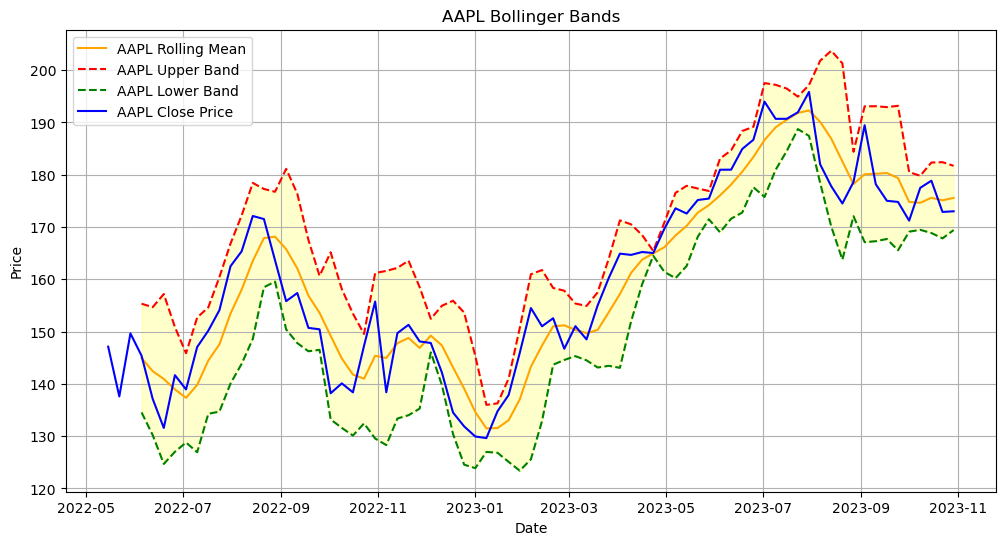

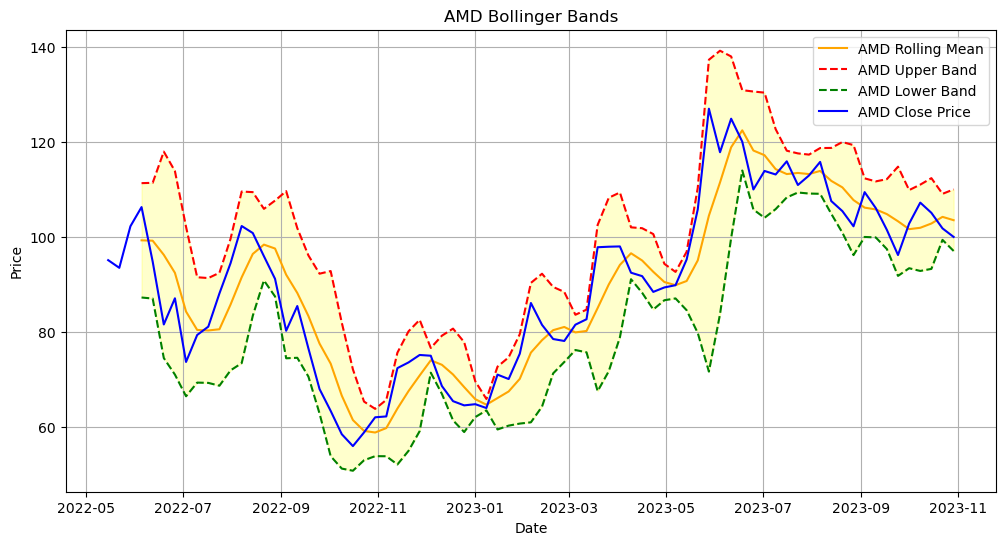

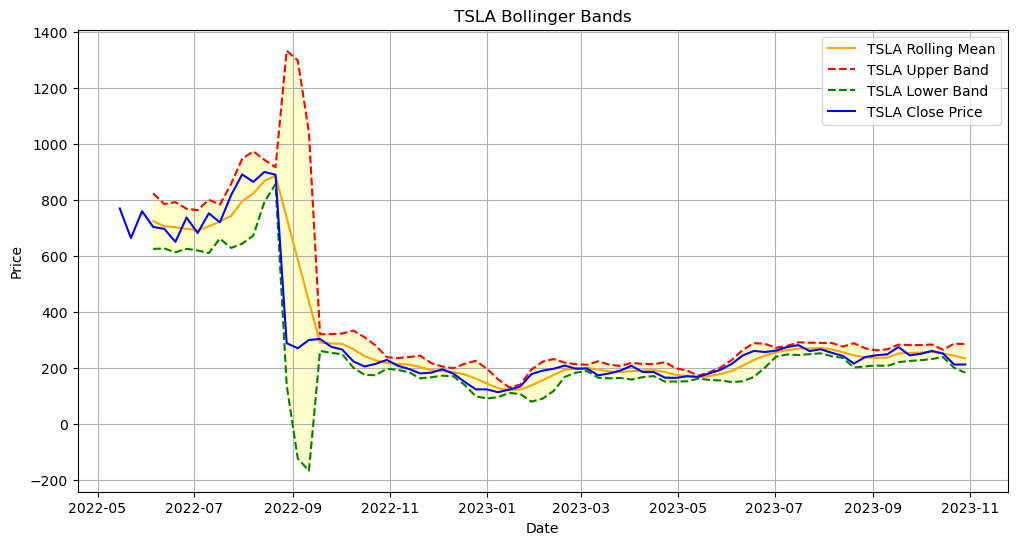

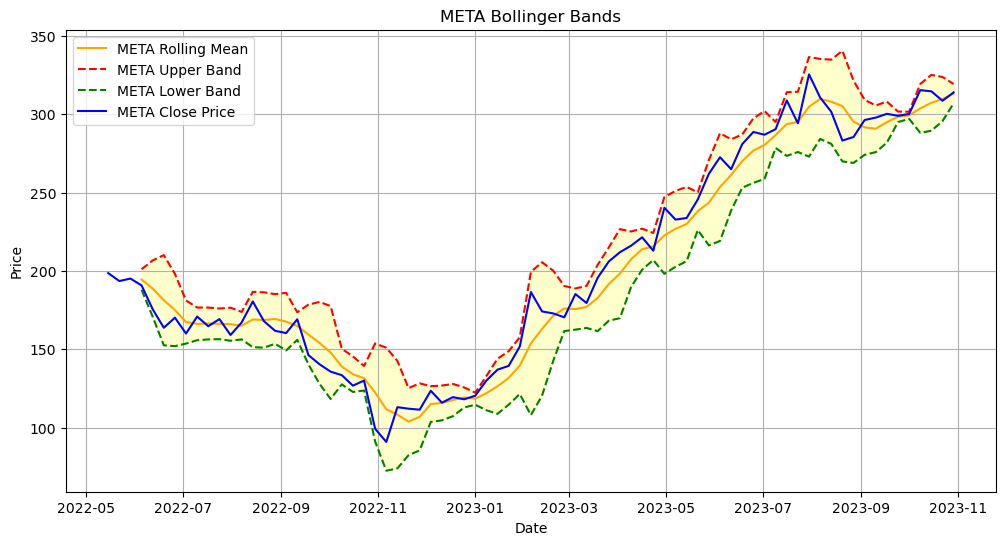

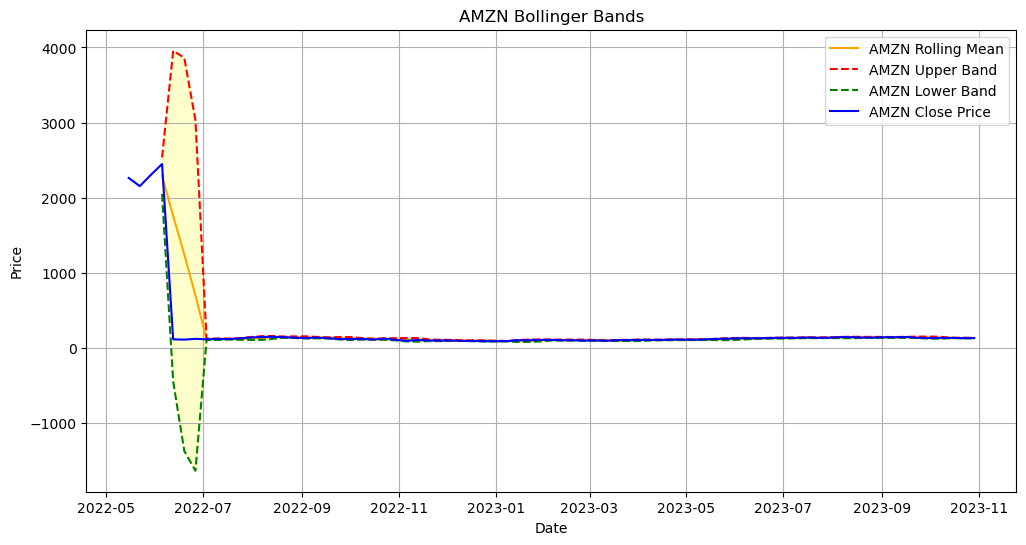

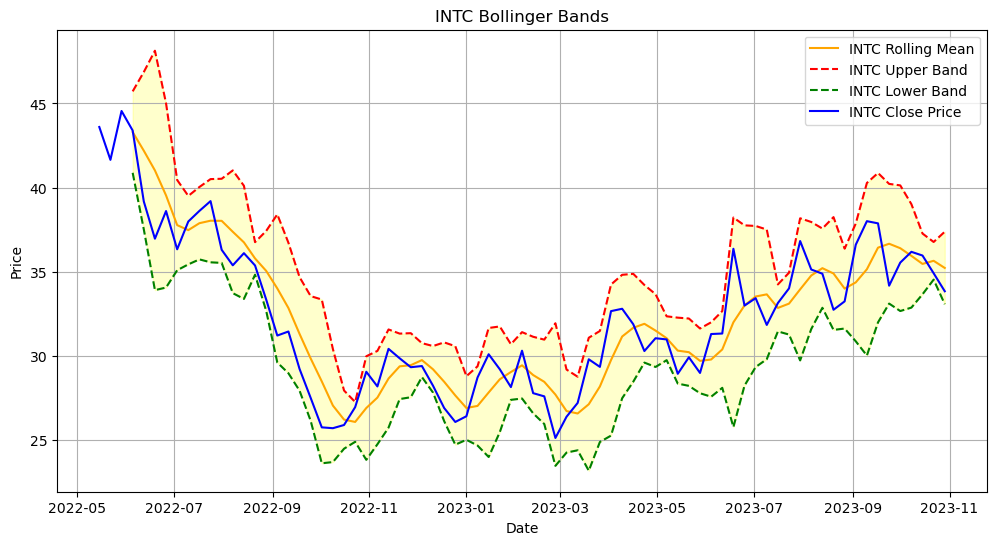

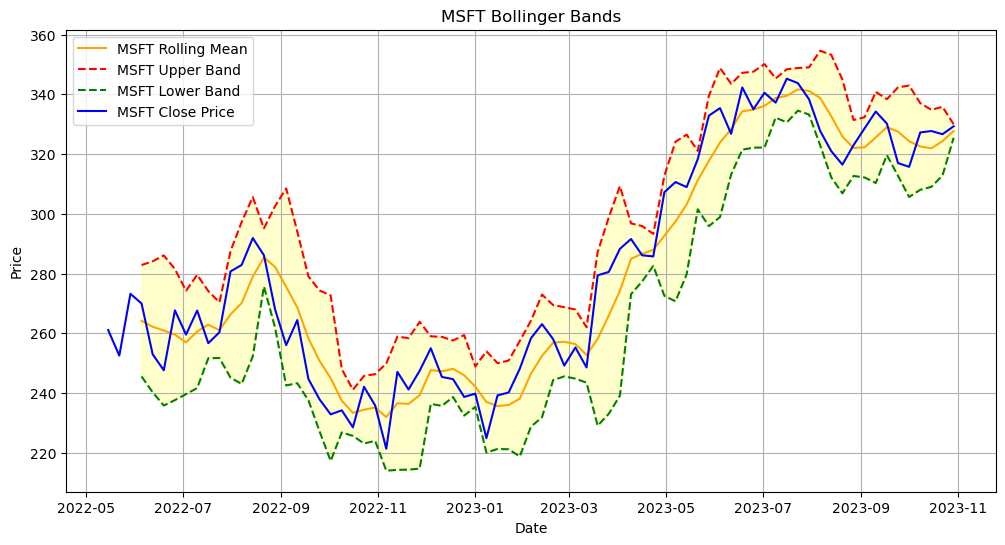

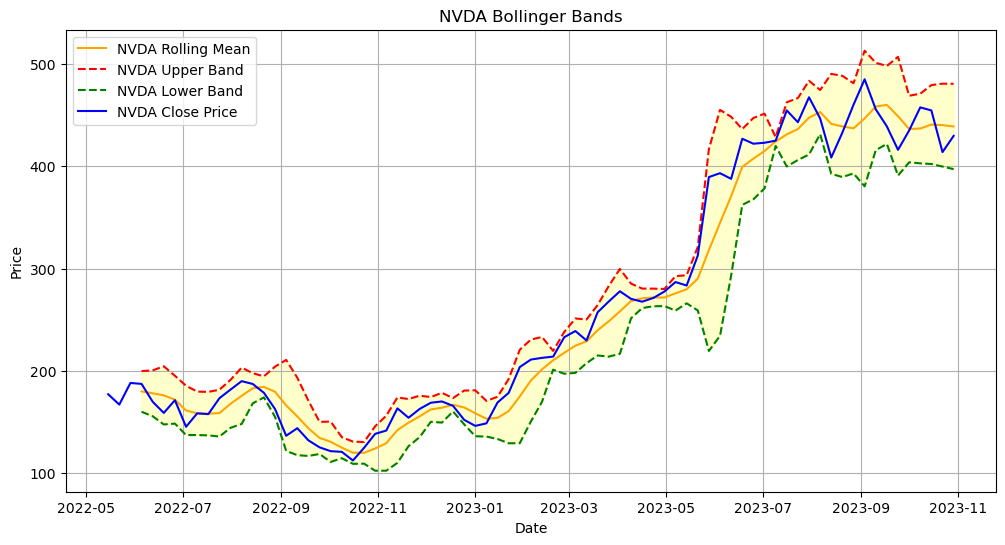

In [17]:
# Looping through stocks 
#1) Filtering data and turning it weekly 
#2) Setting to numeric and making copy as indicated by error
#3) Setting rolling window and runnning function

for stock in my_stocks:
    rolling_window = 4
    selected_stock=stock
    dataframe=all_stocks_clean.query(f"Ticker == '{stock}'")
    dataframe = pd.DataFrame(dataframe)
    dataframe.set_index('Dates', inplace=True)
    dataframe = dataframe.resample('W').last()
    dataframe.reset_index(inplace=True)
    dataframe['Close'] = pd.to_numeric(dataframe['Close'], errors='coerce')
    data = dataframe.query(f"Ticker == '{stock}'")
    stock_df = data[data['Ticker'] == stock].copy()  # Create a copy of the filtered DataFrame
    my_bollinger(stock_df)

    

In [ ]:
# The end